# Heterogeneous medium

In [1]:
# ! pip install jwave
# ! pip install --upgrade "jax[cuda12_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
# ! pip install "jaxlib[cuda]"

In [2]:
%load_ext line_profiler

In [3]:
import numpy as np

from jax import jit
from jax import numpy as jnp
from jaxdf import FourierSeries
from matplotlib import pyplot as plt

from jwave.acoustics import simulate_wave_propagation
from jwave.geometry import *
from jwave.geometry import circ_mask
from jwave.utils import show_field, show_positive_field

domain = Domain((220, 220), (0.5e-3, 0.5e-3))
pml_size = 30

2024-04-22 07:24:52.900468: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [4]:
print("Grid dimensions in meters")
print(np.array(domain.N) * np.array(domain.dx))

Grid dimensions in meters
[0.11 0.11]


In [5]:
print("Grid dimensions in inches")
m_to_inches = 39.3701
print(m_to_inches* np.array(domain.N) * np.array(domain.dx))

Grid dimensions in inches
[4.330711 4.330711]


In [6]:
sound_speed_background = 343  # Background sound speed [m/s]
density_background = 1000  # Background density [kg/m^3]

sound_speed_map=sound_speed_background * np.ones(domain.N)
density_map=density_background * np.ones(domain.N)

In [7]:
max_freq = sound_speed_background/(2*np.min(domain.dx))

max_freq

343000.0

In [8]:
medium = Medium(domain=domain, sound_speed=density_map, density=density_map, pml_size=pml_size)
time_axis = TimeAxis.from_medium(medium, cfl=0.3)
time_axis = TimeAxis.from_medium(medium, cfl=0.2, t_end=time_axis.t_end*4)

In [9]:
import numpy as np

# Layer properties
layer_thicknesses = np.array([0.03, 0.02, 0.04])  # e.g., Drywall, Wood, Insulation, Air Gap, Drywall

# Define the sound speed and density values for each layer according to common building materials
layer_sound_speeds = [1500, 3300, sound_speed_background]  # Sound speed values for Drywall, Wood, Insulation, Air Gap, Background
layer_densities = [800, 600, density_background]  # Density values for Drywall, Wood, Insulation, Air Gap, Background

# Get the dimensions of the kgrid
Nx, Ny = domain.N

# # Set each layer separately in a for loop
# end_index = Ny
# for i, thickness in enumerate(layer_thicknesses[::-1]):  # Reverse the order of layers
#     start_index = end_index - int(thickness / domain.dx[1])
#     print(f"start_index = {start_index}, end_index = {end_index}")
#     # Reverse the order of sound speeds and densities for proper layering
#     sound_speed_map[:, start_index:end_index] = layer_sound_speeds[::-1][i]
#     density_map[:, start_index:end_index] = layer_densities[::-1][i]
#     end_index = start_index

In [10]:
from jwave.geometry import circ_mask

circle_mask = np.zeros(domain.N)
# circle_mask += circ_mask(domain.N, 20, np.array(domain.N)/np.array([4, 2]))
circle_mask += circ_mask(domain.N, 10, np.array(domain.N)*np.array([3/4, 3/4]))
# circle_mask += circ_mask(domain.N, 10, np.array(domain.N)/np.array([2, 3]))
# circle_mask += circ_mask(domain.N, 10, np.array(domain.N)/np.array([4, 4]))
# circle_mask += circ_mask(domain.N, 10, np.array(domain.N)*np.array([3.4/4, 3/5]))
# circle_mask += circ_mask(domain.N, 10, np.array(domain.N)*np.array([3/4, 1/5]))
circle_mask = circle_mask.astype(bool)

sound_speed_map[circle_mask] = 2000
density_map[circle_mask] = 700

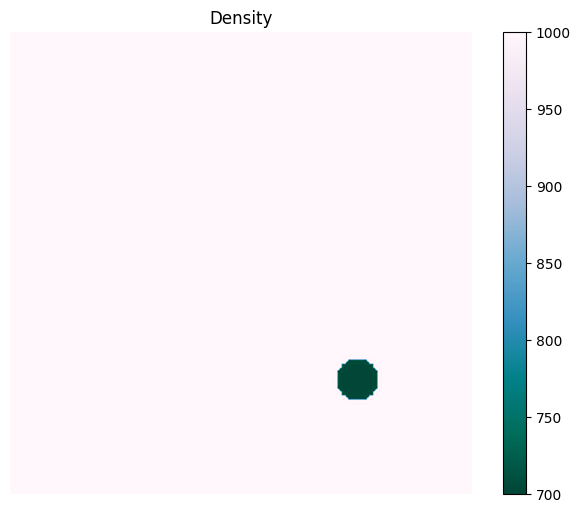

In [11]:
show_positive_field(density_map, aspect=None)
_ = plt.title("Density")

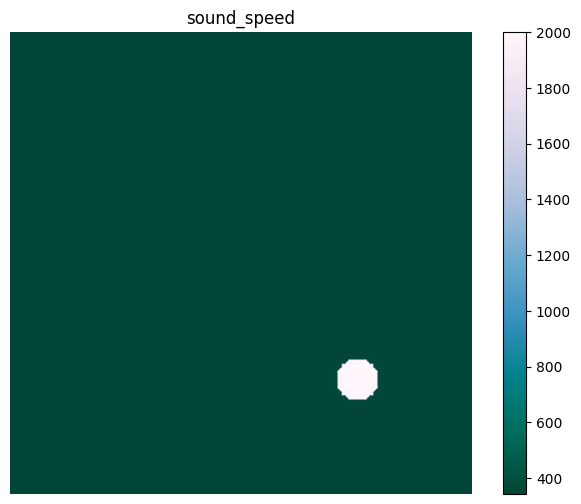

In [12]:
show_positive_field(sound_speed_map, aspect=None)
_ = plt.title("sound_speed")

# Signal source

In [13]:
from kwave.utils.signals import tone_burst

# Define the acoustic source
source_frequency = 1e5  # Source frequency [Hz]
source_amplitude = 1 # Source amplitude [Pa]
source_num_cycles = 5  # Number of cycles in the source tone burst

source_signal = jnp.squeeze(source_amplitude * tone_burst(1 / time_axis.dt, source_frequency, source_num_cycles))  # Create the source signal

assert source_frequency <= max_freq

source_signal.shape

(501,)

In [14]:
t = jnp.arange(0, time_axis.t_end, time_axis.dt)

pad_width = t.shape[0] - len(source_signal)
padded_signal = jnp.pad(source_signal, (0, pad_width), mode='constant')

padded_signal.shape

(6195,)

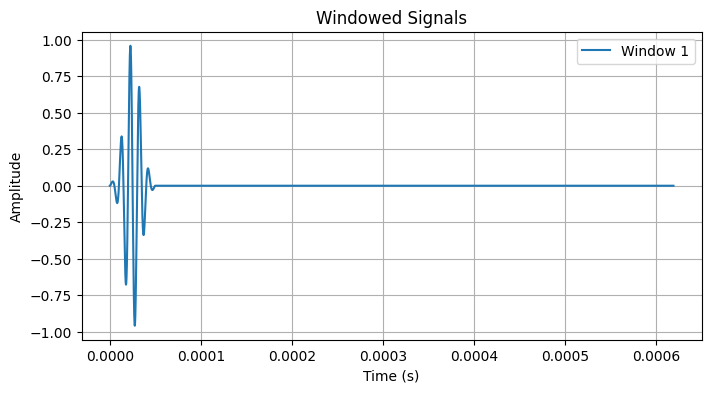

In [15]:
# Plot padded signal
from jwave.signal_processing import gaussian_window
import jax.numpy as jnp
import matplotlib.pyplot as plt

# t = jnp.arange(0, time_axis.t_end, time_axis.dt)
# frequency = 1e6  # Decreased frequency

# s = 200 * jnp.sin(2 * jnp.pi * frequency * t)  # Increased amplitude

s1 = padded_signal
# s2 = gaussian_window(signal=s, time=t, mu=6e-6, sigma=1e-5)  # Adjusted window parameters

plt.figure(figsize=(8, 4))
plt.plot(t, s1, label='Window 1')
# plt.plot(t, s2, label='Window 2')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Windowed Signals')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
from jwave.geometry import Sources

sources = Sources(
    positions=([domain.N[0]//2], [domain.N[1]//6]),
    signals=jnp.stack([s1]),
    dt=time_axis.dt,
    domain=domain,
)

In [17]:
import jaxdf
from typing import Any, Optional

@jit
def compiled_simulator(
    domain: jaxdf.geometry.Domain,
    sound_speed_field,
    density_field, 
    initial_pressure,
    sources=None
):
    medium = Medium(domain=domain, sound_speed=sound_speed_field, density=density_field, pml_size=pml_size)
    return simulate_wave_propagation(
        medium, 
        time_axis, 
        p0=initial_pressure, 
        sources=sources)

In [18]:
from helper.jwave import simulation

In [19]:
num_iterations = 1  # Specify the desired number of iterations
pressure_combined_raw = simulation.run_simulations(compiled_simulator, domain, sound_speed_map, density_map, None, num_iterations, sources)

Starting simulations for 1 iterations


Running simulations:   0%|          | 0/1 [00:00<?, ?it/s]

Rtunning simulation for iteration 1


Running simulations: 100%|██████████| 1/1 [00:01<00:00,  1.88s/it]

Simulation completed for iteration 1
Pressure data concatenated for iteration 1
Simulations completed


Text(0.5, 1.0, 'Pressure field at t=0.0006194000015966594')

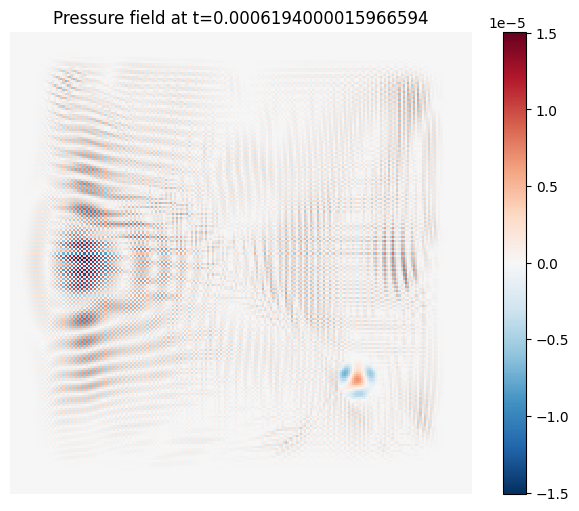

In [20]:
t = -1
show_field(pressure_combined_raw[t], aspect=None)
plt.title(f"Pressure field at t={time_axis.to_array()[t]}")

## Plot and Video

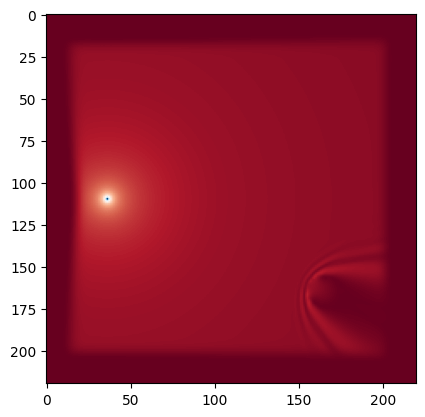

In [21]:
# Max pressure
plt.imshow(jnp.max(pressure_combined_raw, axis=0), aspect=None, cmap="RdBu")

In [22]:
import jax.numpy as jnp

# pressure_combined_raw = jnp.concatenate((pressure.on_grid, pressure_continued.on_grid), axis=0)

In [23]:
from helper.plotting import process_hdr

# pressure_data_hdr = process_hdr(pressure_noncompiled_raw, window_size=10)
pressure_data_hdr = pressure_combined_raw

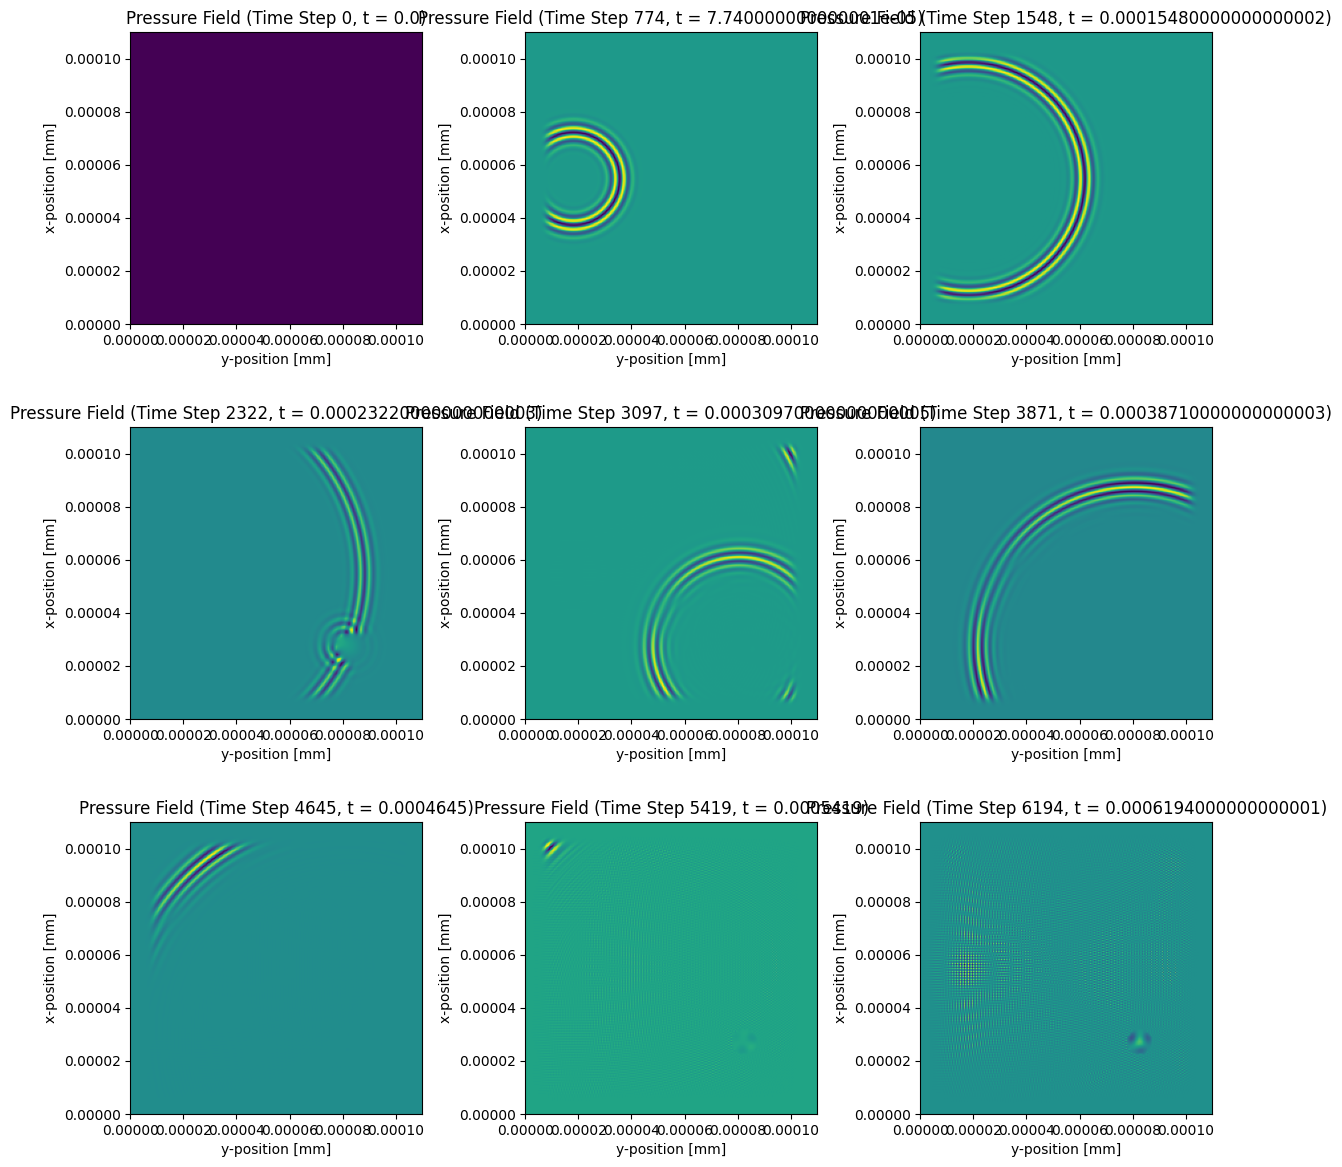

In [24]:
from helper import plotting

plotting.plot_pressure_fields(pressure_data=pressure_data_hdr, domain_size=domain.size, time_axis_dt=time_axis.dt)

In [25]:
pressure_combined = FourierSeries(pressure_combined_raw, domain)

In [ ]:
from jwave.extras.export import save_video

save_video(pressure_combined, './output.mp4', vmax=0.05, vmin=-0.05, fps=50)

 44%|████▍     | 2741/6195 [00:17<00:19, 174.88it/s]

In [ ]:
pressure_combined.on_grid.shape

In [ ]:
# Plot signals for various x values
# for x in range(10, domain.N[0]-10, 30):
#     plt.figure()
#     plt.plot(pressure_combined.on_grid.squeeze()[:, x, 5])
#     plt.title(x)

In [ ]:
# pressure_raw = np.squeeze(pressure_combined)

In [ ]:
# plotting.create_pressure_animation(pressure_data=pressure_data_hdr, domain_size=domain.size, dt=time_axis.dt)

In [ ]:
# stop

# Finite differences

In [ ]:
# pressure = compiled_simulator(
#     domain=domain, 
#     sound_speed_field=FiniteDifferences(np.expand_dims(sound_speed_map, -1), domain), 
#     density_field=FiniteDifferences(np.expand_dims(density_map, -1), domain),
#     initial_pressure=p0
# )

In [ ]:
# t = 270
# show_field(pressure[t])
# plt.title(f"Pressure field at t={time_axis.to_array()[t]}")

# Sensor

In [ ]:
# import jwave
# help(jwave.geometry)

In [ ]:
# # sensors
# num_sensors = 64
# x, y = points_on_circle(num_sensors, 20, (32, 32))
# sensors_positions = (jnp.array(x), jnp.array(y))
# sensors = Sensors(positions=sensors_positions)

In [ ]:
# # sensors
# num_sensors = 64
# x = np.linspace(0, domain.N[0], num_sensors).astype(int).tolist()
# y = (5 * np.ones(len(x))).astype(int).tolist()
# sensors_positions = (jnp.array(x), jnp.array(y))
# sensors = Sensors(positions=sensors_positions)

In [ ]:
# from matplotlib import pyplot as plt

# fig = plt.figure(figsize=(8, 8))
# ax = fig.add_subplot()
# ax.scatter(x, y, marker="o", color="black")
# ax.set_title("Sensor locations")
# ax.set_xlim(0, domain.N[0])
# ax.set_ylim(0, domain.N[1])

In [ ]:
# def get_sensor_data():
#     sound_speed_field=FourierSeries(np.expand_dims(sound_speed_map, -1), domain)
#     density_field=FourierSeries(np.expand_dims(density_map, -1), domain)
#     medium = Medium(domain=domain, sound_speed=sound_speed_field, density=density_field, pml_size=pml_size)
#     return simulate_wave_propagation(medium, time_axis, p0=p0, sources=sources, sensors=sensors)

# sensor_data = get_sensor_data()

In [ ]:
# plt.imshow(sensor_data[..., 0].T, aspect="auto", cmap="RdBu")
# plt.title("Sensors traces")

In [ ]:
# medium = Medium(domain=domain, sound_speed=sound_speed, density=density, pml_size=40)
# pressure_noncompiled = simulate_wave_propagation(medium, time_axis, p0=p0)

In [ ]:
# jnp.squeeze(transducer_array.elements[0].mask.on_grid.shape)

# Tranducer array

In [ ]:
import importlib
import jwave
importlib.reload(jwave)
importlib.reload(jwave.geometry)

In [ ]:
from jwave.geometry import TransducerArray

transducer_array = TransducerArray(domain=domain,
                                   num_elements=30,
                                   element_width=domain.dx[0]*4,
                                   element_height=domain.dx[1]*2,
                                   element_spacing=domain.dx[0]*2,
                                   position=(domain.N[0] // 2 * domain.dx[0], 25 * domain.dx[1]),
                                   signal=jnp.stack([padded_signal]),
                                   sound_speed=sound_speed_background,
                                   dt=time_axis.dt,
                                   focus_distance=(domain.N[1] // 2) * domain.dx[1], # halfway in grid
                                   steering_angle=0
                                  )

In [ ]:
# Assuming transducer_array is an instance of TransducerArray with 2D domain
mask_2d = transducer_array.get_segmentation_mask()
plt.figure(figsize=(8, 6))
plt.imshow(mask_2d, cmap='viridis')
plt.colorbar(label='Transducer element Index')
plt.title('Transducer Segmentation Mask (2D)')
plt.xlabel('Y Axis')
plt.ylabel('X Axis')
plt.show()

In [ ]:
p0 = None

def get_sensor_data(sources, sensors):
    sound_speed_field=FourierSeries(np.expand_dims(sound_speed_map, -1), domain)
    density_field=FourierSeries(np.expand_dims(density_map, -1), domain)
    medium = Medium(domain=domain, sound_speed=sound_speed_field, density=density_field, pml_size=pml_size)
    return simulate_wave_propagation(
        medium, 
        time_axis, 
        p0=p0,
        sources=sources, 
        sensors=sensors
    )

transducer_array.set_active_elements(np.ones(transducer_array.num_elements))
sensor_data_onetime = get_sensor_data(sources=transducer_array, sensors=transducer_array)

In [ ]:
sensor_data_onetime.shape

In [ ]:
def plot_sensor_data(sensor_data):
    plt.figure(figsize=(10, 6))
    plt.imshow(jnp.expand_dims(sensor_data.T, -1), aspect="auto", cmap="RdBu")
    plt.title("Sensor traces")

    # Add x-axis labels
    plt.xticks(range(0, sensor_data.T.shape[1], 100), range(1, sensor_data.T.shape[1] + 1, 100))
    plt.xlabel("Time Index")

    # Add y-axis labels
    plt.yticks(range(0, sensor_data.T.shape[0]), range(0, sensor_data.T.shape[0]))
    plt.ylabel("Sensor Index")

    # Add grid lines
    plt.grid(which="major", axis="y", linestyle="-", linewidth=0.5, color="white")

    # Adjust tick positions
    plt.colorbar(label="Sensor Value")
    
plot_sensor_data(sensor_data_onetime)

In [ ]:
# transducer_array.set_active_elements([False, False, False, False])
# transducer_array.elements[0].is_active = False
# transducer_array.elements[1].set_is_active(True)

# [element.is_active for element in transducer_array.elements]

In [ ]:
# Assuming transducer_array is an instance of TransducerArray with 2D domain
mask_2d = transducer_array.get_segmentation_mask()
plt.figure(figsize=(8, 6))
plt.imshow(mask_2d, cmap='viridis')
plt.colorbar(label='Transducer element Index')
plt.title('Transducer Segmentation Mask (2D)')
plt.xlabel('Y Axis')
plt.ylabel('X Axis')

plt.show()

In [ ]:
# Set the middle transducer on
from helper import plotting

active_elements = np.zeros(transducer_array.num_elements)
active_elements[len(active_elements)//2] = 1

# active_elements = np.ones(transducer_array.num_elements)

transducer_array.set_active_elements(active_elements)
sensor_data = get_sensor_data(sources=transducer_array, sensors=None)
plotting.plot_pressure_fields(pressure_data=sensor_data.on_grid, domain_size=domain.size, time_axis_dt=time_axis.dt)

In [ ]:
# Plot max sensor data
plt.imshow(jnp.max(sensor_data.on_grid, axis=0), aspect=None, cmap="RdBu")

In [ ]:
from jwave.extras.export import save_video

save_video(sensor_data, './output_transducer.mp4', vmax=0.05, vmin=-0.05, fps=50)

In [ ]:
from helper.transducer import generate_active_elements

# Range of steering angles to test
# steering_angles = np.arange(-32, 33, 2)
number_scan_lines = transducer_array.num_elements
# number_scan_lines = transducer.number_elements
WINDOW_SIZE = 1
active_elements = generate_active_elements(
    number_scan_lines=number_scan_lines, 
    transducer_number_elements=transducer_array.num_elements, 
    window_size=WINDOW_SIZE)

plt.imshow(active_elements)

In [ ]:
from helper import reconstruction
# def run_scan_lines(create_from_scratch):
scan_lines = np.zeros((int(time_axis.Nt), number_scan_lines))
scan_lines_nobeamform = np.zeros((int(time_axis.Nt), transducer_array.num_elements, number_scan_lines,))

for scan_index in range(number_scan_lines):
    print(f'Computing scan line {scan_index} of {number_scan_lines}')

    # Update the current active elements
    transducer_array.set_active_elements(active_elements[scan_index])    

    # Update the target position
    active_elements_indices = np.nonzero(active_elements[scan_index])[0]    
    middle_active_element = active_elements_indices[len(active_elements_indices) // 2]

    # print(f"middle_active_element: {middle_active_element}")

    middle_element_pos = transducer_array.elements[middle_active_element].center_pos

    # print(f"middle_element_pos: {middle_element_pos}")

    new_target_point = (middle_element_pos[0], middle_element_pos[1] + transducer_array.focus_distance)

    # print(f"new_target_point: {new_target_point}")

    transducer_array.set_target_point(new_target_point)    

    sensor_data = get_sensor_data(sources=transducer_array, sensors=transducer_array)

    # scan_lines_nobeamform[:, :, scan_index] = sensor_data
    scan_lines_nobeamform[:, active_elements[scan_index].astype(bool), scan_index] = sensor_data

    # scan_lines[:, scan_index] = transducer_array.scan_line(sensor_data) # [:int(time_axis.Nt)]
    scan_line = transducer_array.scan_line(sensor_data)

    scan_line_trimmed = reconstruction.trim_scan_lines(
        scan_lines=jnp.expand_dims(scan_line, -1),
        input_signal=source_signal,
        max_delay_in_samples=transducer_array.max_delay_in_samples
    ).squeeze()

    # plt.plot(scan_line[transducer_array.max_delay_in_samples:])
    # scan_lines[:, scan_index] = scan_line[transducer_array.max_delay_in_samples:]
    scan_lines[:, scan_index] = scan_line_trimmed
    # print(f"scan_line.shape: {scan_line.shape}")
    # print(f"scan_line_trimmed.shape: {scan_line_trimmed.shape}")
    # print(transducer_array.max_delay_in_samples)

        # return scan_lines

In [ ]:
# # Plot signals for each scan line
# for index in range(number_scan_lines):
#     # _ = plt.plot(scan_lines_nobeamform[:1000, index, index])
#     # plotting.plot_pressure_fields(
#     #     pressure_data=scan_lines_nobeamform[:, index, index], 
#     #     domain_size=domain.size, 
#     #     time_axis_dt=time_axis.dt
#     # )
    
#     # plot_sensor_data(
#     #     scan_lines_nobeamform[:, :, index]
#     # )
    
#     plt.figure()
#     plt.plot(scan_lines_nobeamform[:, :, index])
#     plt.title(x)       

In [ ]:
# _ = plt.plot(scan_lines[:1000, :])

In [ ]:
# %lprun -f run_scan_lines run_scan_lines(True)

In [ ]:
# %lprun -f run_scan_lines run_scan_lines(False)

In [ ]:
# %lprun -f TransducerArray._create_elements TransducerArray._create_elements(transducer_array)

In [ ]:
# stop

# Trim signal from scan lines

In [ ]:
scan_lines_trimmed = scan_lines[round(len(source_signal) - len(source_signal)/2):, :]

scan_lines_trimmed.shape

In [ ]:
# Combine elements per scan line

In [ ]:
ax = plot_sensor_data(scan_lines)
plt.axvline(x=int(len(source_signal) - len(source_signal)/2), color='cyan', linestyle='-', linewidth=1.5)

In [ ]:
plot_sensor_data(scan_lines_trimmed)

In [ ]:
plot_sensor_data(sensor_data_onetime)

In [ ]:
from kwave.utils.filters import gaussian_filter

scan_lines_fund = gaussian_filter(scan_lines_trimmed.T, 1/time_axis.dt, source_frequency, 100)
scan_lines_harm = gaussian_filter(scan_lines_trimmed.T, 1/time_axis.dt, 2 * source_frequency, 30)

In [ ]:
from kwave.reconstruction.beamform import envelope_detection

scan_lines_fund = envelope_detection(scan_lines_fund)
scan_lines_harm = envelope_detection(scan_lines_harm)

In [ ]:
from kwave.reconstruction.tools import log_compression

compression_ratio = 3
scan_lines_fund = log_compression(scan_lines_fund, compression_ratio, True)
scan_lines_harm = log_compression(scan_lines_harm, compression_ratio, True)

In [ ]:
scan_lines_fund.shape

In [ ]:
image_size = [domain.N[0] * domain.dx[0], domain.N[1] * domain.dx[1]]
image_res = [256, 256]
# Create the axis variables
x_axis = [0, image_size[0] * 1e3] # [mm]
y_axis = [0, image_size[1] * 1e3]  # [mm]

plt.subplot(132)
plt.imshow(scan_lines_fund, aspect='auto',
            extent=[number_scan_lines, 0, y_axis[1], y_axis[0]],  
           interpolation='none', 
           cmap='bone')
# plt.xlabel('Steering angle [deg]')
plt.xlabel('Depth [mm]')
plt.title('Processed Scan-Line Data')

In [ ]:
show_positive_field(sound_speed_map, aspect=None)
_ = plt.title("sound_speed")